In [1]:
import pandas as pd
import pathlib
import sys
from functools import partial
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
import warnings

path = str(pathlib.Path().resolve().parent)
sys.path.append(path)
sys.path.append(path+'/src/')
warnings.simplefilter("ignore")

from src.preprocessing import *

In [2]:
path

'C:\\Users\\sylvi\\Documents\\GitHub\\fake_news_detection'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
data = pd.read_csv(path + '/data/final_merged_dataset.csv',index_col = 0)

#Feature nb of retweets :

data['nb_retweets'] = data['tweet'].apply(count_retweets)

#Feature nb of mentions :

data['nb_mentions'] = data['tweet'].apply(count_mentions)

#Feature nb of urls:

data['nb_urls'] = data['tweet'].apply(count_urls)

#Feature nb of hashtags :

data['nb_hashtags'] = data['tweet'].apply(count_hashtags)

# Remove emojis :

data['tweet'] = data['tweet'].apply(remove_emojis)

# Remove retweets :

data['tweet'] = data['tweet'].apply(remove_retweets)

# Remove mentions :

data['tweet'] = data['tweet'].apply(remove_mentions)

# Remove urls :

data['tweet'] = data['tweet'].apply(remove_urls)

# Remove hashtags :

data['tweet'] = data['tweet'].apply(remove_hashtags)

# Replace slash chars (\n, \t, \r) by space :

data['tweet'] = data['tweet'].apply(replace_slash_chars_by_space)

# Remove underscore :

data['tweet'] = data['tweet'].apply(remove_underscore)

# Remove html stuff (like &lt;) :

data['tweet'] = data['tweet'].apply(remove_html_stuff)

# To lowercase :

data['tweet'] = data['tweet'].apply(to_lowercase)

# Remove stopwords :

with open(path + "/data/english_stopwords.txt",mode="r") as f:
    stopwords = f.read().split('\n')

additional_stopwords = [] # to change
to_remove_stopwords = [] # to change

final_stopwords = [s for s in stopwords if s not in to_remove_stopwords]
final_stopwords += additional_stopwords

remove_stp_words = partial(remove_stopwords,list_stopwords=final_stopwords)

data['tweet'] = data['tweet'].apply(remove_stp_words)

# Remove additional white space :

data['tweet'] = data['tweet'].apply(remove_additional_space)

data.head()

,tweet,label,nb_retweets,nb_mentions,nb_urls,nb_hashtags
0,two weeks coronavirus media coverage and: new ...,0,1,1,0,0
1,"ever here, congratulations, immune coronavirus",0,1,1,1,0
2,you’ve ever used frat house bathroom you’re im...,0,1,1,0,0
3,cocaine cures corona virus!! . got interesting...,0,1,1,0,0
4,it’s almost whole lot americans covid immune s...,0,1,1,0,0


Distribution du nombre de mots entre Fake news et Real news :

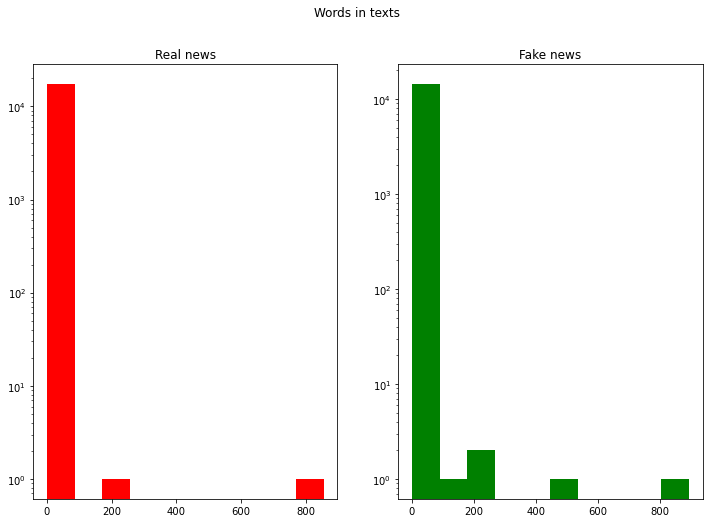

In [4]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==1]['tweet'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red',log=True)
ax1.set_title('Real news')
text_len=data[data['label']==0]['tweet'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green',log=True)
ax2.set_title('Fake news')
fig.suptitle('Words in texts')
plt.show()

Word cloud des vrai news :

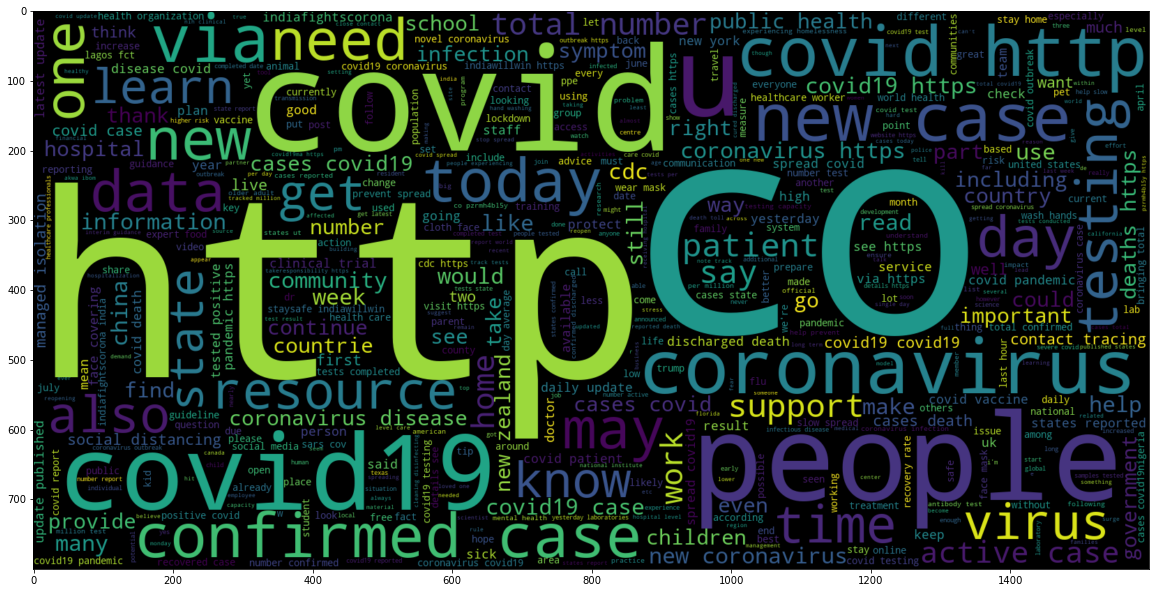

In [5]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = stopwords).generate(" ".join(data[data.label == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear');

Wordcloud des fake news :

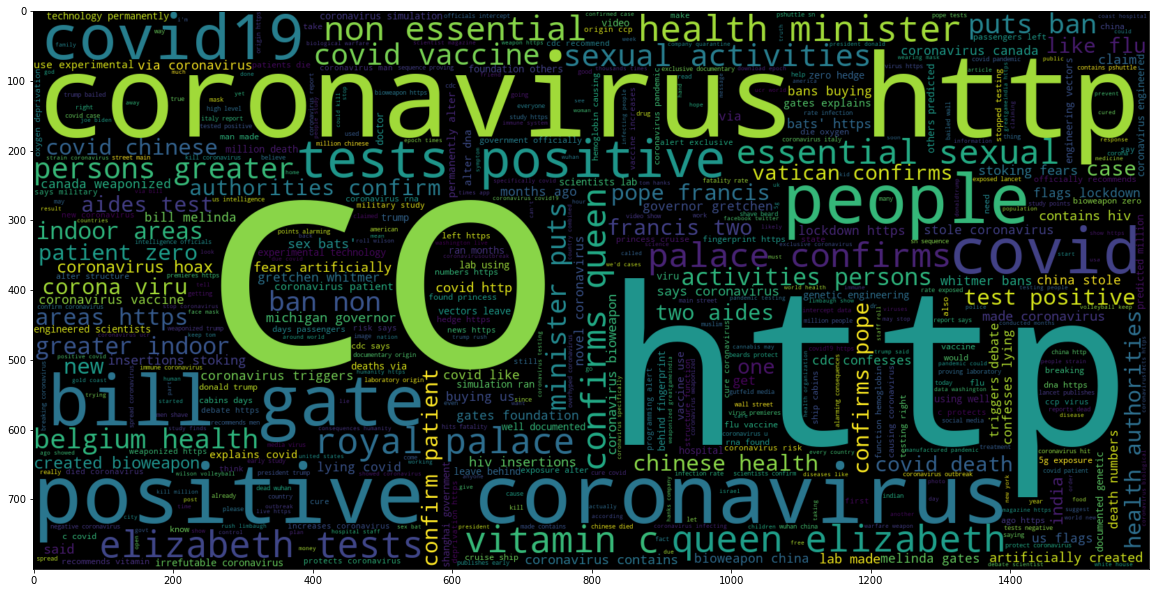

In [6]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = stopwords).generate(" ".join(data[data.label == 0].tweet))
plt.imshow(wc , interpolation = 'bilinear');

Comparaison de la longueur des mots entre fake et real news :

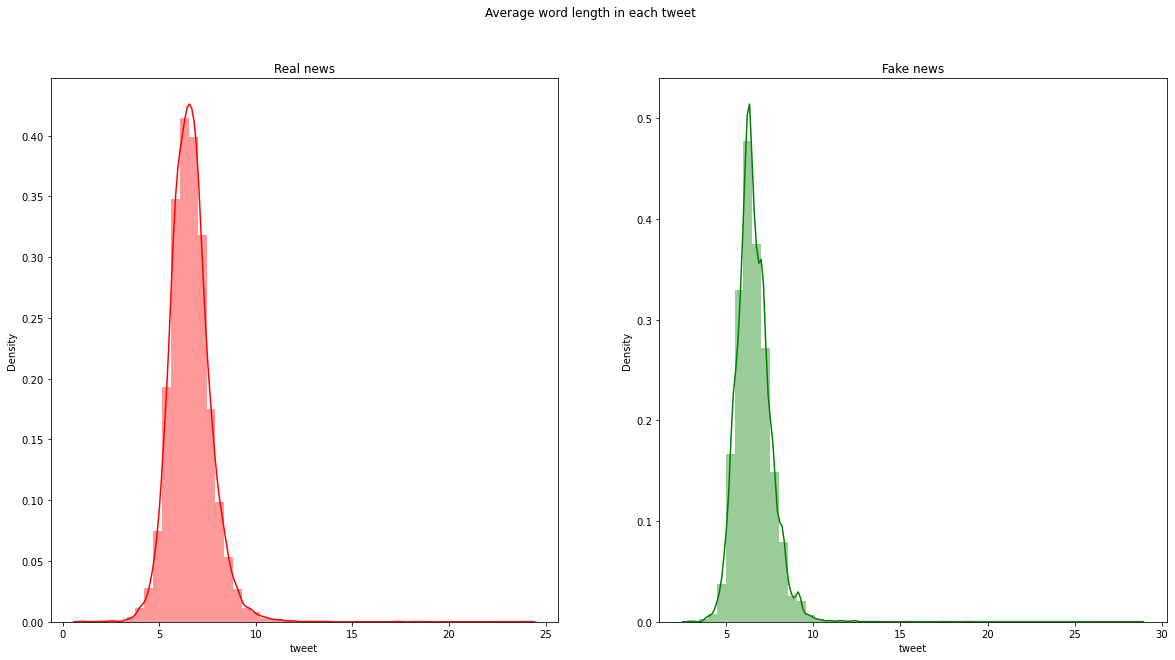

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=data[data['label']==1]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Real news')
word=data[data['label']==0]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake news')
fig.suptitle('Average word length in each tweet');

In [5]:
train_df, val_df = train_val_split(data)
X_train = train_df['tweet'].values
y_train = train_df['label'].values
X_val = val_df['tweet'].values
y_val = val_df['label'].values

In [6]:
max_words = 1000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = sequence.pad_sequences(train_sequences,maxlen=max_len)
val_sequences = tok.texts_to_sequences(X_val)
val_sequences_matrix = sequence.pad_sequences(val_sequences,maxlen=max_len)

In [9]:
# embedding_dim =100
# embeddings_index = dict()
# f = open('../data/glove.6B.100d.txt',encoding = 'utf-8')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:],dtype='float32')
#     embeddings_index[word]= coefs
# f.close()

# # create embedding matrix
# embedding_matrix = np.zeros((max_words,embedding_dim))
# for word, index in tok.word_index.items():
#     if index > max_words-1:
#         break
#     else:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index]= embedding_vector
# embedding_matrix.dump("embedding.dat")

In [7]:
embedding_dim =100
embedding_matrix = np.load("../data/embedding.dat", allow_pickle=True)

In [8]:
embedding_matrix.shape

(1000, 100)

In [9]:
from keras.layers import LSTM

In [47]:
def RNN():
    inputs = keras.Input(name='inputs',shape=[max_len])
    layer = keras.layers.Embedding(max_words,embedding_dim,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                    trainable = False)(inputs)
    layer = keras.layers.LSTM(64,dropout = 0.2, recurrent_dropout = 0.2)(layer)
    layer = keras.layers.Dense(128)(layer)
    layer = keras.layers.Dropout(0.5)(layer)
    layer = keras.layers.Dense(1,name='out_layer')(layer)
    layer = keras.layers.Activation('sigmoid')(layer)
    model = keras.Model(inputs=inputs,outputs=layer)
    return model

In [48]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 200)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 200, 100)          100000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 129       
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0  

In [49]:
train = model.fit(train_sequences_matrix,y_train,batch_size=128,epochs=15,
          validation_split=0.1
              )

Epoch 1/15
203/203 [==============================] - 146s 707ms/step - loss: 0.5209 - accuracy: 0.7383 - val_loss: 0.4139 - val_accuracy: 0.8069
Epoch 2/15
203/203 [==============================] - 267s 1s/step - loss: 0.4087 - accuracy: 0.8124 - val_loss: 0.3600 - val_accuracy: 0.8458
Epoch 3/15
203/203 [==============================] - 195s 963ms/step - loss: 0.3581 - accuracy: 0.8402 - val_loss: 0.3194 - val_accuracy: 0.8622
Epoch 4/15
203/203 [==============================] - 132s 653ms/step - loss: 0.3312 - accuracy: 0.8541 - val_loss: 0.3092 - val_accuracy: 0.8601
Epoch 5/15
203/203 [==============================] - 126s 623ms/step - loss: 0.3133 - accuracy: 0.8634 - val_loss: 0.3128 - val_accuracy: 0.8587
Epoch 6/15
203/203 [==============================] - 129s 636ms/step - loss: 0.2990 - accuracy: 0.8701 - val_loss: 0.2933 - val_accuracy: 0.8708
Epoch 7/15
203/203 [==============================] - 123s 607ms/step - loss: 0.2882 - accuracy: 0.8754 - val_loss: 0.2826 - va

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


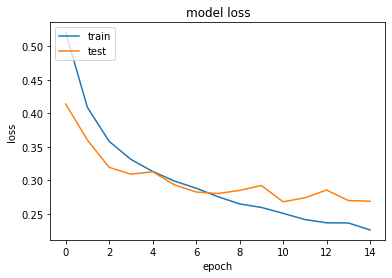

In [50]:
print(train.history.keys())
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
y_pred = model.predict(val_sequences_matrix)
y_pred = (y_pred > 0.5).astype('int').ravel()
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1463
           1       0.87      0.89      0.88      1738

    accuracy                           0.87      3201
   macro avg       0.87      0.87      0.87      3201
weighted avg       0.87      0.87      0.87      3201

